In [1]:
%matplotlib inline
import os
import numpy as np
import xarray as xr
import dask

import matplotlib.pyplot as plt
from collections import OrderedDict

from itertools import product
from functools import partial

import obm

Consider amplitude of thermal and biological forcing

In [2]:
model = obm.onebox.surface_mixed_layer()

In [19]:
ncp_harmonic = partial(obm.forcing_tools.harmonic, mu=0., phase=-0.5, N=365, steps_per_period=365)
sst_harmonic = partial(obm.forcing_tools.harmonic, mu=7., phase=-0.5, N=365, steps_per_period=365)

forcing_func = lambda therm, bio: model.init_forcing(nday=365., dt=1., 
                                         NCP=ncp_harmonic(amp=bio), 
                                         TEMP=sst_harmonic(amp=therm))



In [22]:
%%time
do_dask = False
if do_dask:
    model_run = dask.delayed(model.run)
else:
    model_run = model.run


results = []
case = []
thermal_forcing = []
biological_forcing = []



state_init = [2088., 308.]
for therm, bio in product(range(0, 1), range(0, 4)):
    casename = f'orcas.gasex-t{therm:03d}-b{bio:03d}'
    case.append(casename)
    thermal_forcing.append(therm)
    biological_forcing.append(bio)
    
    init_file = f'{casename}.npy'
    init_option = 'fsolve'
    
    if os.path.exists(init_file) and not clobber:
        init_option = 'file'
        
    out = model_run(time_stop=365., 
                    forcing=forcing_func(therm, bio),
                    init_option=init_option,
                    init_file=init_file,
                    state_init=state_init)
    
    results.append(out)

if do_dask:
    results = dask.compute(*results)
    
case = xr.DataArray(case, dims=('case'), name='case')
ds = xr.concat(results, dim=case)
ds['thermal_forcing'] = xr.DataArray(thermal_forcing, dims=('case'))
ds['biological_forcing'] = xr.DataArray(biological_forcing, dims=('case'))

CPU times: user 18.9 s, sys: 298 ms, total: 19.2 s
Wall time: 19.3 s


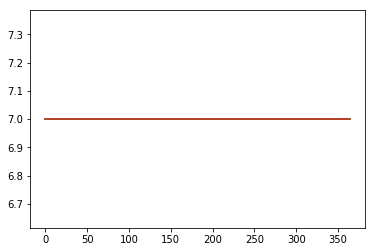

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111)
for case in ds.case:
    dsc = ds.sel(case=case)
    ax.plot(dsc.TEMP)

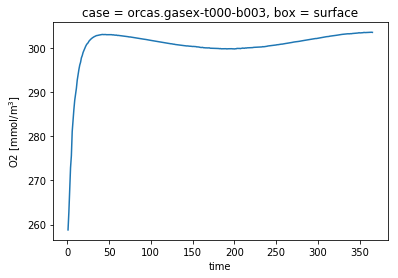

In [15]:
dsc.O2.plot()

In [ ]:
out.O2.plot()

In [ ]:
out.DIC.values[-1]

In [ ]:
out.O2.values[-1]

In [ ]:
out.NCP.plot()